In [1]:
from collections import defaultdict
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys; sys.path.append("models")
from config import get_case_config, get_case_sensitivities
import sensitivity, utils
from strategies import RETURN_KEYS

from chart_books import *

In [2]:
def config_files(folder):
    return filter(lambda x: x.startswith("config") and x.endswith('.json'), os.listdir(folder))

def run_fname(cfg_fname):
    return cfg_fname.replace("config", "run").replace("json", 'csv')

def resgen(data_dir):
    lockdowns = next(os.walk(data_dir))[1]
    for lockdown in lockdowns:
        folder = os.path.join(data_dir, lockdown)
        for cfg_file in config_files(folder):
            cfg = utils.read_json(os.path.join(folder, cfg_file))
            target = cfg[sensitivity.TARGET_KEY]
            results = pd.read_csv(os.path.join(folder, run_fname(cfg_file)), index_col=0)
            yield lockdown, target, cfg[sensitivity.CONFIG_KEY], results

In [3]:
import utils
import config
keys_to_plot = [RETURN_KEYS.reduced_r, RETURN_KEYS.tests]
rc_dct = {
    'figure.figsize': (7, 6),
    'figure.max_open_warning': 1000,
    "errorbar.capsize": 2.5,
#     "errorbar.capwidth": 2.5
}
chart_folder = os.path.join(os.environ['REPOS'], 'tti-explorer', 'charts')
input_folder = os.path.join(os.environ['DATA'], "tti-explorer", "new_results")

In [4]:
measures_order =  [
     'no_TTI',
    'symptom_based_TTI',
     'test_based_TTI',
     'test_based_TTI_test_contacts',
]

def legend(ax):
    return ax.legend(
        bbox_to_anchor=(0.5, -0.10),
        loc='upper center',
        ncol=4,
        fancybox=False,
        framealpha=1,
        frameon=True
    )


def plot_lockdown(lockdown_dct, deck, key_to_plot, order=measures_order, formatters={}):
    for param_name, sim_results in lockdown_dct.items():
        tick_formatter = formatters.get(param_name)
        fig, ax = plt.subplots(1)
        for measure in order:
            res = sim_results[measure]
            plot_sim_results(ax, res, key_to_plot, nice_lockdown_name(measure))
        legend(ax)
        ax.set_ylabel(key_to_plot)
        ax.set_xlabel(nice_param_name(param_name))
        if tick_formatter is not None:
            ax.xaxis.set_major_formatter(tick_formatter)
        deck.add_figure(fig, name=param_name)
    return fig

In [5]:
from matplotlib.ticker import FuncFormatter
perc_formatter = FuncFormatter(lambda x, _: f"{100*x:.0f}%")
formatters = {
    'app_cov': perc_formatter,
    'trace_adherence': perc_formatter    
}
plt.style.use("seaborn-ticks")

# Pinch Points

In [6]:
pinch_points_dir = os.path.join(input_folder, "pinch-points")
pinch_points_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for lockdown, target, cfg, results in resgen(pinch_points_dir):
    if target in ['testing_delay', 'manual_trace_delay']:
        continue
    if int(lockdown[1]) > 0:
        level, measures = lockdown.split('_', maxsplit=1)
        pinch_points_results[level][target][measures].append((cfg[target], results))

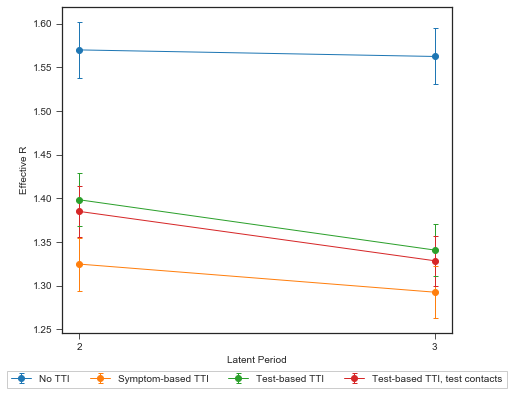

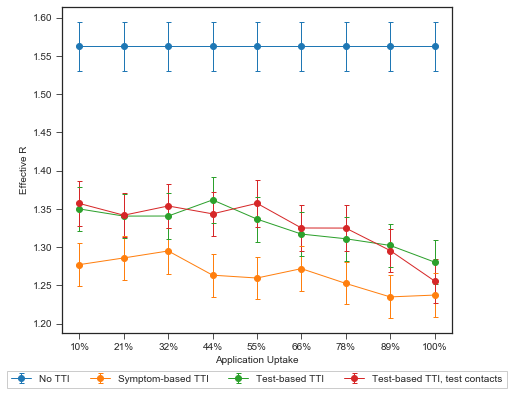

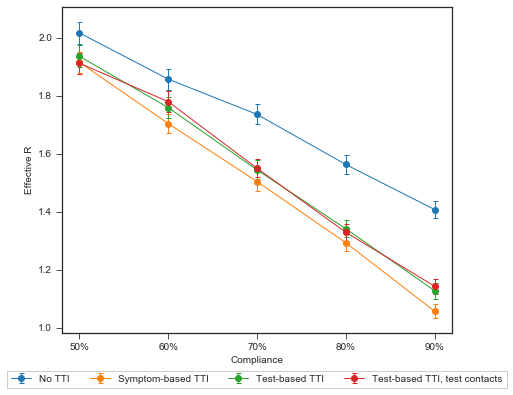

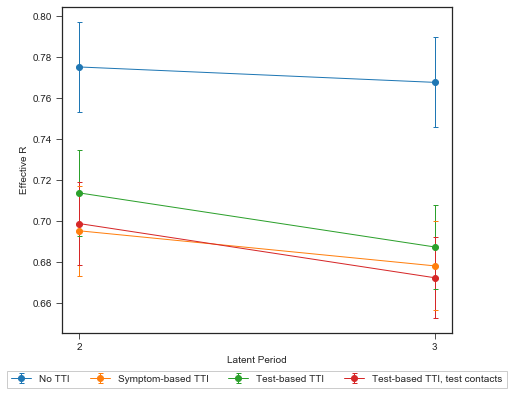

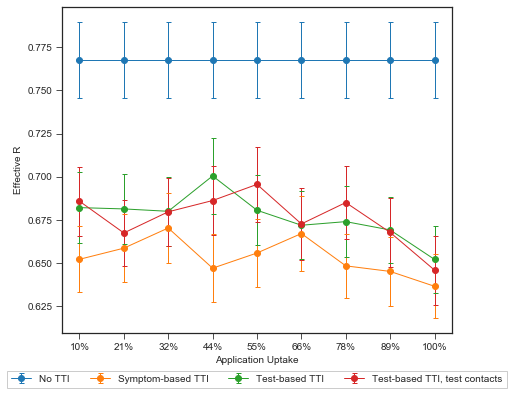

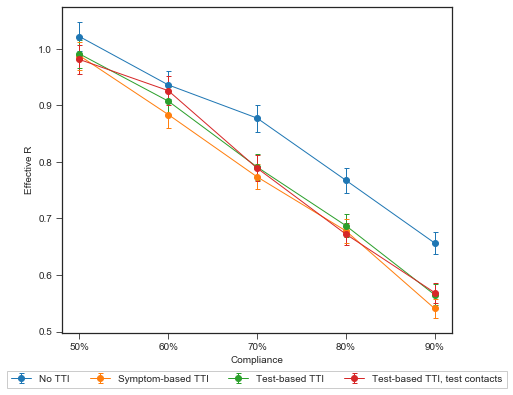

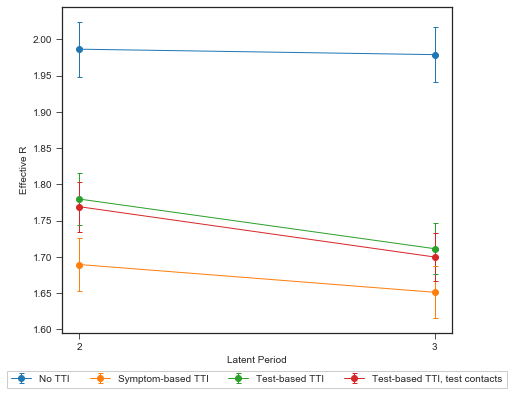

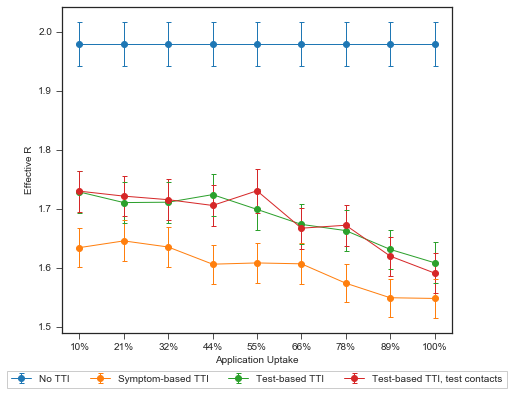

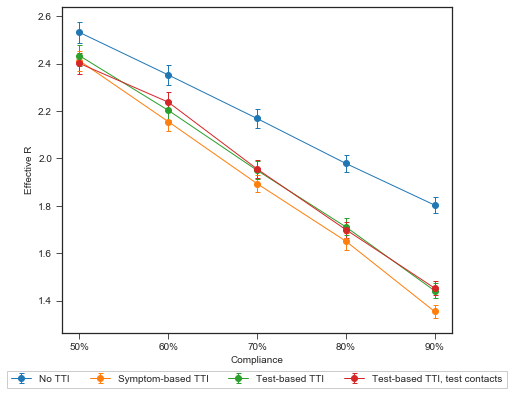

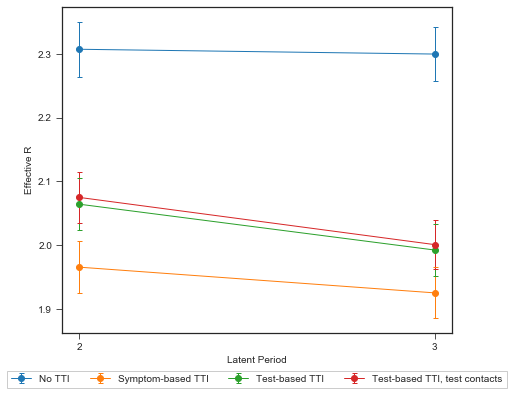

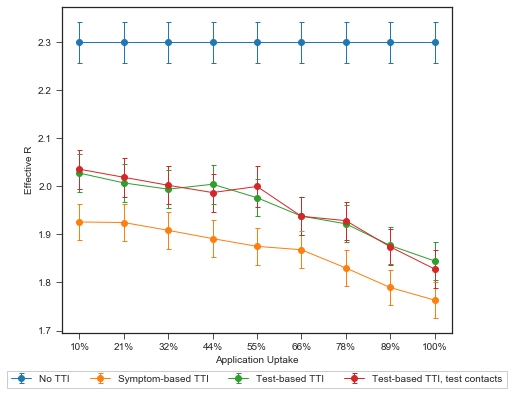

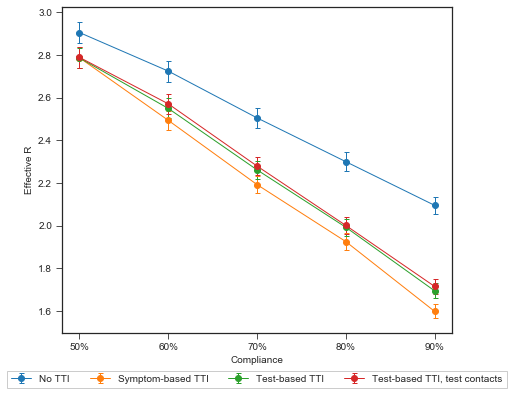

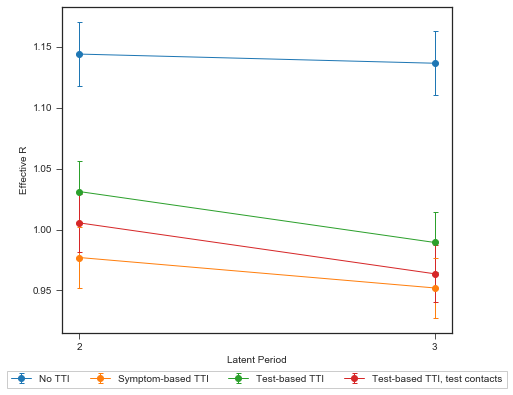

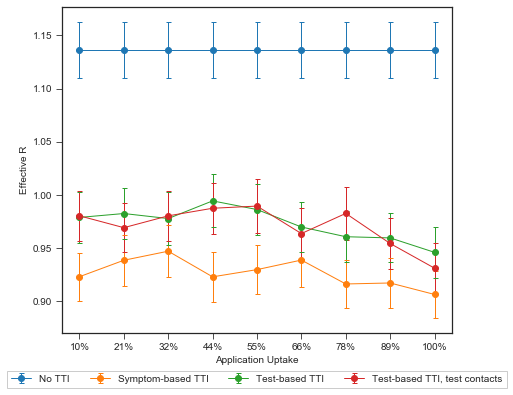

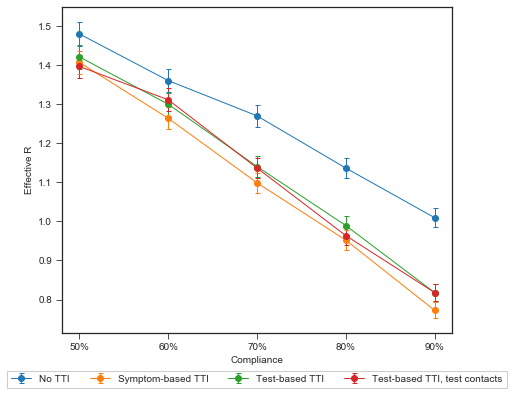

In [7]:
with plt.rc_context(rc_dct):
    for level, results in pinch_points_results.items():
        deck = utils.PdfDeck()
        plot_lockdown(results, deck, RETURN_KEYS.reduced_r, formatters=formatters)
        deck.make(os.path.join(chart_folder, f"{level}_pinch_points.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)

# Test Trace Tables

In [8]:
tt_dir = os.path.join(input_folder, "pinch-points-test-trace-delay")
test_trace_results = defaultdict(lambda: defaultdict(list))
for lockdown, target, cfg, results in resgen(tt_dir):
    if int(lockdown[1]) > 0:
        vals = [cfg[k] for k in target]
        level, measures = lockdown.split('_', maxsplit=1)
        results = results.set_index(config.STATISTIC_COLNAME, drop=True)[keys_to_plot]
        test_trace_results[level][measures].append((vals, results))  

In [9]:
def make_tables(entry, key=RETURN_KEYS.reduced_r):
    coords, reslist = zip(*entry)
    means, stds = zip(*[(k[key]['mean'], k[key]['std']) for k in reslist])
    means_mat = pd.DataFrame(np.array(utils.sort_by(means, coords, return_idx=False)).reshape(3, 3))
    stds_mat = pd.DataFrame(np.array(utils.sort_by(stds, coords, return_idx=False)).reshape(3, 3))
    return means_mat, stds_mat


def format_table(means, stds):
    t1, t2 = ['Test Delay (days)', 'Manual Trace Delay (days)']

    table = means.applymap(
            lambda x: f"{x:.2f}"
        ).add(
            " \pm "
        ).add(
            stds.mul(
                1.96 
            ).applymap(
                lambda x: f"{x:.2f}"
            )
        ).applymap(lambda x: f"${x}$")
    
    table.index =  range(1, 4)
    table.columns = range(1, 4)
    table.index.name = t1
    table.columns.name = t2
    return table

In [10]:
table_deck = utils.LatexTableDeck()

for k in sorted(test_trace_results.keys()):
    table_deck.add_section(f"Lockdown Level {k}")
    for policy, entry in test_trace_results[k].items():
        means, stds = make_tables(entry, key=RETURN_KEYS.reduced_r)
        table = format_table(means, stds)
        table_deck.add_table(
            tex_table=table.to_latex(escape=False),
            caption=nice_lockdown_name(policy)
        )
    table_deck.clearpage()
table_deck.make("test-trace-tables.tex")

In [11]:
# two charts for covid and flue like
# do num tests and num contact tracings needed for infection proportions

# Sensitivity

In [12]:
inf_props_mapping = {
     'oxteam_infection_proportions0_seed0': "vary_flu0",
     'oxteam_infection_proportions1_seed0': "vary_flu1",
     'oxteam_infection_proportions2_seed0': "vary_flu2",
     'oxteam_infection_proportions3_seed0': "vary_flu3",
     'oxteam_infection_proportions4_seed0': "vary_covid0",
     'oxteam_infection_proportions5_seed0': "vary_covid1",
     'oxteam_infection_proportions6_seed0': "vary_covid2"
}

In [13]:
case_sensitivity_results = defaultdict(dict)
case_sensitivity_dir = os.path.join(input_folder, 'case-sensitivity')
for lockdown, target, cfg, results in resgen(case_sensitivity_dir):
    if lockdown[1] == '0': 
        continue
    level, measures = lockdown.split("_", maxsplit=1)
    case_sensitivity_results[level][measures] = pd.read_csv(
        os.path.join(case_sensitivity_dir, lockdown, "run_0.csv"),
        index_col=0
    ).drop('oxteam_infection_proportions7_seed0').rename(index=inf_props_mapping)

In [14]:
case_sensitivity_results[level].keys()

dict_keys(['symptom_based_TTI', 'test_based_TTI_test_contacts', 'no_TTI', 'test_based_TTI'])

In [15]:
res = case_sensitivity_results[level]
by_param = pd.concat(res, axis=0).groupby(level=1, by=plotter._grouper)
for k,v in by_param:
    print(k)

NameError: name 'plotter' is not defined

In [ ]:
import config

class LockdownSensitivityPlotter:
    # BE: need to sort out this naming bullshit
    def __init__(self):
        self.ticklabel_maps = {
            'inf_profile': np.array([f"{int(x)}" for x in (np.array([2.11, 2.8, 3.49]) - 1)/0.69]),
             'vary_flu': np.array([f"{k}k" for k in [50, 100, 200, 300]]),
             'vary_covid': np.array([f"{k}k" for k in [10, 20, 30]]),
             'p_day_noticed_symptoms': np.array(['2', '3', '4']),
        }
        self.xlabels = {
             'inf_profile': "Day on which primary case is most infectious",
             'vary_flu': "# COVID negative cases with COVID like symptoms (daily)",
             'vary_covid': "# COVID positive cases (daily)",
             'p_day_noticed_symptoms': "Expected day on which primary case reports symptoms"
        }
        self.param_map = {
                 'oxteam_inf_profile11_seed0': 0,
                 'oxteam_inf_profile12_seed0': 1,
                 'oxteam_inf_profile13_seed0': 2,
                 'oxteam_p_day_noticed_symptoms10_seed0': 0,
                 'oxteam_p_day_noticed_symptoms8_seed0': 2,
                 'oxteam_p_day_noticed_symptoms9_seed0': 1,
                 'vary_flu0': 0,
                 'vary_flu1': 1,
                 'vary_flu2': 2,
                 'vary_flu3': 3,
                 'vary_covid0': 0,
                 'vary_covid1': 1,
                 'vary_covid2': 2
            }
        
    def _grouper(self, s):  ## not neat!
        for i in range(10):
            s = s.replace(f"{i}", "")
        return s.replace("oxteam_", "").replace("_seed", "")
    
    def _plot_parameter(self, ax, results_df, key):
        for measure, dfstats in results_df[[key, config.STATISTIC_COLNAME]].groupby(level=0):
            dfstats = dfstats.droplevel(0).rename(self.param_map)
            mean = dfstats.query(
                f"{config.STATISTIC_COLNAME}=='mean'"
            ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
            std = dfstats.query(
                f"{config.STATISTIC_COLNAME}=='std'"
            ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
            xaxis = mean.index.values
            errorbar(ax, xaxis, mean.values, std.values, label=nice_lockdown_name(measure))
        return xaxis
            
    def __call__(self, results, deck, key_to_plot):
        by_param = pd.concat(results, axis=0).groupby(level=1, by=self._grouper)
        for param_name, v in by_param:
            fig, ax = plt.subplots(1)
            xaxis = self._plot_parameter(ax, v, key_to_plot)
            ax.set_xticks(xaxis)
            ax.set_xticklabels(self.ticklabel_maps[param_name][xaxis])
            ax.set_xlabel(self.xlabels[param_name])
            ax.set_ylabel(key_to_plot)
            legend(ax)
            deck.add_figure(fig, name=param_name)
            

In [ ]:
with plt.rc_context(rc_dct):
    plotter = LockdownSensitivityPlotter()
    for level, results in case_sensitivity_results.items():
        deck = utils.PdfDeck()
        plotter(results, deck, RETURN_KEYS.reduced_r)
        deck.make(os.path.join(chart_folder, f"{level}_sensitivity.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)